In [104]:
%pip install control

Note: you may need to restart the kernel to use updated packages.


In [105]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import control as ctrl

print("Setup Complete")

Setup Complete


In [133]:
ppg_filepath = "../golden_data/ppg_golden_data.csv"

ppg_data = pd.read_csv(ppg_filepath, nrows=10000)

In [134]:
b_s = [0, 0, 0, 0, 14641] 
a_s = [1, 28.74438523, 413.1198405, 3478.070613, 14641]

system_s = ctrl.TransferFunction(b_s, a_s)
system_z = ctrl.sample_system(system_s, 1/100, method='tustin')
b_z, a_z = system_z.num[0][0], system_z.den[0][0]

print(a_z)
print(b_z)

[ 1.         -3.71291523  5.17923851 -3.21646505  0.75026859]
[7.92609259e-06 3.17043703e-05 4.75565555e-05 3.17043704e-05
 7.92609258e-06]


In [135]:

# Hàm lọc tín hiệu sử dụng các hệ số z-domain
def apply_filter(data, b, a):
    data = np.asarray(data, dtype=np.float64)  # Đảm bảo dữ liệu đầu vào là kiểu float64
    y = np.zeros_like(data, dtype=np.float64)  # Tạo mảng kết quả kiểu float64
    for i in range(len(data)):
        y[i] = b[0] * data[i]
        for j in range(1, len(b)):
            if i-j >= 0:
                y[i] += b[j] * data[i-j]
        for j in range(1, len(a)):
            if i-j >= 0:
                y[i] -= a[j] * y[i-j]
    return y


In [136]:
# Định nghĩa các tham số
fs = 50.0  # Tần số lấy mẫu, ví dụ 50 Hz
ws = 10
wp = 5
order = 4  # Bậc của bộ lọc ở miền s

b_z_low = [0,	5.35617889287357e-06,	5.56603268403827e-05,	5.26057994909257e-05,	4.52185201307133e-06]
a_z_low = [1,	-3.71800951758217,	5.19310810021585,	-3.22909001061018,	0.754109572133735]

# Áp dụng bộ lọc
filtered_sig = apply_filter(ppg_data, b_z_low, a_z_low)

# # Số phần tử
# n = 100

# # Bước thời gian
# dt = 0.02  # giây

# # Tạo mảng thời gian
# t = np.linspace(0, (n-1)*dt, n)

# # Tần số của tín hiệu
# f = 0.5  # Hz

# # Tạo tín hiệu sóng sin
# signal = np.sin(2 * np.pi * f * t)
b_z_hi = [0.969531252908746,  -0.969531252908746]
a_z_hi = [1.000000000000000,  -0.939062505817492]

# Áp dụng bộ lọc
filtered_sig1 = apply_filter(filtered_sig, b_z_hi, a_z_hi)


In [137]:
print(filtered_sig)
print(ppg_data)

[[0.00000000e+00]
 [5.25441149e-03]
 [7.94092126e-02]
 ...
 [8.26073624e+02]
 [8.26649163e+02]
 [8.27318396e+02]]
      975
0     981
1     984
2     989
3     992
4     994
...   ...
9995  798
9996  785
9997  770
9998  773
9999  783

[10000 rows x 1 columns]


<Axes: >

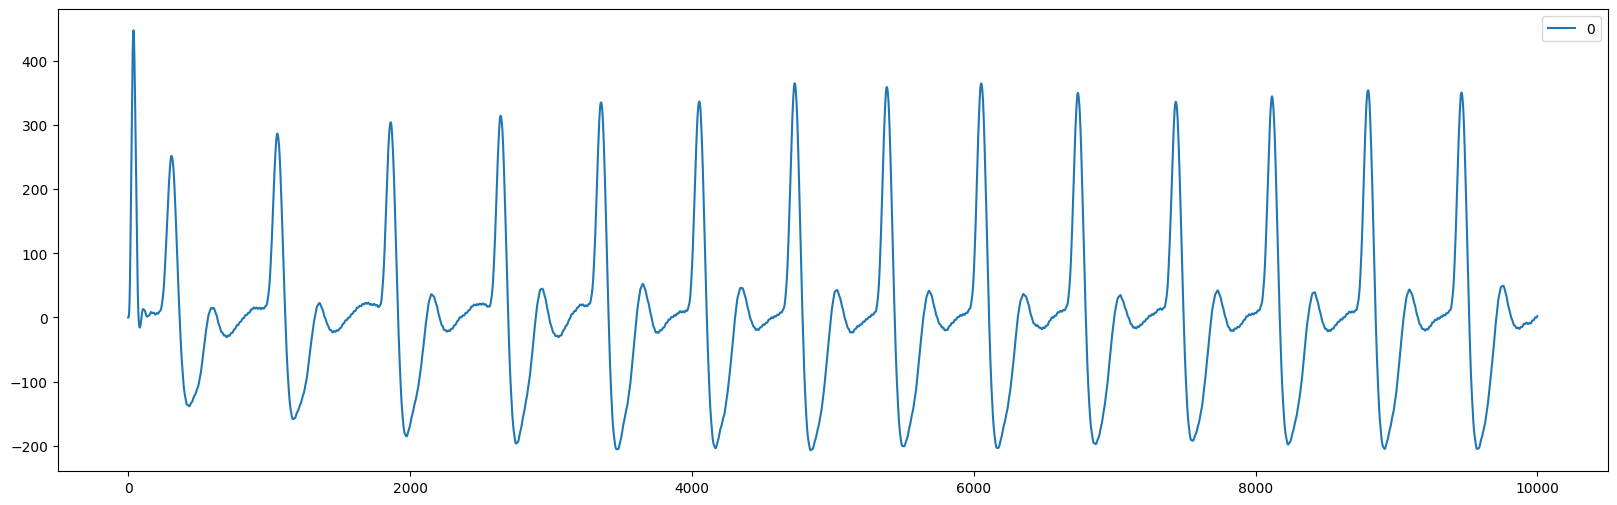

In [138]:
# Hiển thị tín hiệu trước và sau khi lọc
plt.figure(figsize=(20,6))
sns.lineplot(data=filtered_sig1)